In [767]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

In [768]:
signal_df = pd.read_csv('../data/daily_absa_2022.csv')
sp500_df = pd.read_excel('../data/sp_500_constituents.xlsx')

In [769]:
sp500_df

,PERMNO,Company Name,Ticker,SP500 Start,SP500 End,Search Keywords
0,10104,ORACLE CORP,ORCL,"Aug. 3, 1989","Dec. 31, 2024","ORCL, Oracle, Oracle Corp"
1,10107,MICROSOFT CORP,MSFT,1994-06-07 00:00:00,"Dec. 31, 2024","MSFT, Microsoft, Microsoft Corp"
2,10138,T ROWE PRICE GROUP INC,TROW,"Oct. 13, 1999","Dec. 31, 2024","T Rowe Price, T Rowe Price Group Inc, TROW, T ..."
3,10145,HONEYWELL INTERNATIONAL INC,HON,"Dec. 31, 1925","Dec. 31, 2024","HON, Honeywell, Honeywell International Inc"
4,10516,ARCHER DANIELS MIDLAND CO,ADM,1981-07-30 00:00:00,"Dec. 31, 2024","ADM, Archer Daniels Midland, Archer Daniels Mi..."
...,...,...,...,...,...,...
540,85331,Axon Enterprise,AXON,2023-05-04 00:00:00,"Dec. 31, 2024","AXON, Axon Enterprise"
541,76043,Fair Isaac,FICO,2023-03-20 00:00:00,"Dec. 31, 2024","FICO, Fair Isaac"
542,88537,Bunge Global,BG,2023-03-15 00:00:00,"Dec. 31, 2024","BG, Bunge Global"
543,92083,Insulet,PODD,2023-03-15 00:00:00,"Dec. 31, 2024","Insulet, PODD"


In [770]:
Counter(signal_df[signal_df['date'] == '2020-09-28 16:04:37+00:00']['entity'])

Counter()

In [771]:
signal_df[signal_df['date'] == '2020-12-03 19:15:59+00:00']

,Unnamed: 0,date,entity,classification,softmax,article_count


In [772]:
import re
import pandas as pd

# --- 1) Helpers --------------------------------------------------------------

# normalize names/tickers to make matching robust
def _norm(s: str) -> str:
    if pd.isna(s): 
        return ""
    s = s.lower()
    s = s.replace("&", " and ")
    # remove common company suffixes
    s = re.sub(r"\b(co|corp|corporation|inc|inc\.|ltd|plc|company|the)\b", " ", s)
    # keep only letters/digits/spaces
    s = re.sub(r"[^a-z0-9 ]+", " ", s)
    # collapse spaces
    s = re.sub(r"\s+", " ", s).strip()
    return s

def _split_keywords(s: str):
    if pd.isna(s) or not s:
        return []
    # keywords appear comma-separated (and sometimes with slashes/pipes/semicolons)
    return [k.strip() for k in re.split(r"[,\|/;]", s) if k.strip()]

# --- 2) Build a normalized keyword → ticker map from sp500_df ----------------

# Collect all aliases for each row: Ticker, Company Name, and Search Keywords
aliases_map = {}
for _, r in sp500_df.iterrows():
    ticker = str(r.get("Ticker", "")).strip()
    comps = [ticker, str(r.get("Company Name", ""))]
    comps += _split_keywords(str(r.get("Search Keywords", "")))
    # add both raw and normalized variants to the dictionary
    for alias in comps:
        if not alias:
            continue
        aliases_map[_norm(alias)] = ticker

# --- 3) Exact/alias match on normalized entity --------------------------------

signal_df = signal_df.copy()
signal_df["entity_norm"] = signal_df["entity"].map(_norm)
signal_df["matched_ticker"] = signal_df["entity_norm"].map(aliases_map)



In [773]:
signal_df.matched_ticker.value_counts().head(10)

matched_ticker
SO      2185
LOW     2090
KEY     2035
TGT     1714
D       1699
FAST    1616
MET     1570
META    1525
PEAK    1320
AMZN    1307
Name: count, dtype: int64

In [774]:
signal_df = signal_df.drop_duplicates(subset=['matched_ticker', 'date'])

In [775]:
signal_df[signal_df['matched_ticker'] == 'MSFT'].sort_values('date')

,Unnamed: 0,date,entity,classification,softmax,article_count,entity_norm,matched_ticker
131,131,2017-01-07,MSFT,NEUTRAL,"{'positive': 0.00512064435483458, 'neutral': 0...",1,msft,MSFT
191,191,2017-01-10,MSFT,NEUTRAL,"{'positive': 0.008088285103440285, 'neutral': ...",1,msft,MSFT
214,214,2017-01-11,MSFT,NEUTRAL,"{'positive': 0.008143684826791286, 'neutral': ...",1,msft,MSFT
237,237,2017-01-12,MSFT,NEUTRAL,"{'positive': 0.0027094562246929854, 'neutral':...",2,msft,MSFT
301,301,2017-01-16,MSFT,NEUTRAL,"{'positive': 0.02324111945927143, 'neutral': 0...",2,msft,MSFT
...,...,...,...,...,...,...,...,...
43987,43987,2022-12-07,MSFT,NEUTRAL,"{'positive': 0.0036216621985659, 'neutral': 0....",2,msft,MSFT
44068,44068,2022-12-12,MSFT,NEUTRAL,"{'positive': 0.26476004435459066, 'neutral': 0...",3,msft,MSFT
44108,44108,2022-12-14,MSFT,NEUTRAL,"{'positive': 0.0019427028018981218, 'neutral':...",1,msft,MSFT
44273,44273,2022-12-25,MSFT,NEUTRAL,"{'positive': 0.0019399661105126143, 'neutral':...",1,msft,MSFT


In [776]:
signal_df.iloc[-100:]

,Unnamed: 0,date,entity,classification,softmax,article_count,entity_norm,matched_ticker
44281,44281,2022-12-26,PEAK,NEGATIVE,"{'positive': 0.003283629019279033, 'neutral': ...",2,peak,PEAK
44282,44282,2022-12-26,PM,NEUTRAL,"{'positive': 0.0045317779295146465, 'neutral':...",1,pm,PM
44283,44283,2022-12-26,SO,NEUTRAL,"{'positive': 0.006143586467563485, 'neutral': ...",6,so,SO
44284,44284,2022-12-26,TGT,NEUTRAL,"{'positive': 0.4458931088447571, 'neutral': 0....",1,tgt,TGT
44285,44285,2022-12-27,D,NEUTRAL,"{'positive': 0.0012751518515869975, 'neutral':...",1,d,D
...,...,...,...,...,...,...,...,...
44376,44376,2023-01-01,SO,NEUTRAL,"{'positive': 0.009118871345708612, 'neutral': ...",4,so,SO
44377,44377,2023-01-01,SQ,NEUTRAL,"{'positive': 0.007900673896074295, 'neutral': ...",1,sq,SQ
44378,44378,2023-01-01,TGT,NEUTRAL,"{'positive': 0.015752156924766798, 'neutral': ...",1,tgt,TGT
44379,44379,2023-01-01,TSLA,NEUTRAL,"{'positive': 0.0005311636195983738, 'neutral':...",2,tsla,TSLA


In [777]:
signal_df

,Unnamed: 0,date,entity,classification,softmax,article_count,entity_norm,matched_ticker
0,0,2017-01-01,AAPL,NEUTRAL,"{'positive': 0.010230648680590093, 'neutral': ...",2,aapl,AAPL
1,1,2017-01-01,AMZN,NEUTRAL,"{'positive': 0.19124966114759445, 'neutral': 0...",1,amzn,AMZN
2,2,2017-01-01,APP,NEUTRAL,"{'positive': 0.06706008844159762, 'neutral': 0...",2,app,APP
3,3,2017-01-01,BMY,NEUTRAL,"{'positive': 0.0006146261584945023, 'neutral':...",1,bmy,BMY
4,4,2017-01-01,D,NEUTRAL,"{'positive': 0.05939907248102827, 'neutral': 0...",4,d,D
...,...,...,...,...,...,...,...,...
44376,44376,2023-01-01,SO,NEUTRAL,"{'positive': 0.009118871345708612, 'neutral': ...",4,so,SO
44377,44377,2023-01-01,SQ,NEUTRAL,"{'positive': 0.007900673896074295, 'neutral': ...",1,sq,SQ
44378,44378,2023-01-01,TGT,NEUTRAL,"{'positive': 0.015752156924766798, 'neutral': ...",1,tgt,TGT
44379,44379,2023-01-01,TSLA,NEUTRAL,"{'positive': 0.0005311636195983738, 'neutral':...",2,tsla,TSLA


In [778]:
len(signal_df['matched_ticker'].unique())

50

In [779]:
classification_counts = Counter(signal_df['classification'])
classification_counts.most_common(10)

[('NEUTRAL', 37242), ('NEGATIVE', 4429), ('POSITIVE', 2710)]

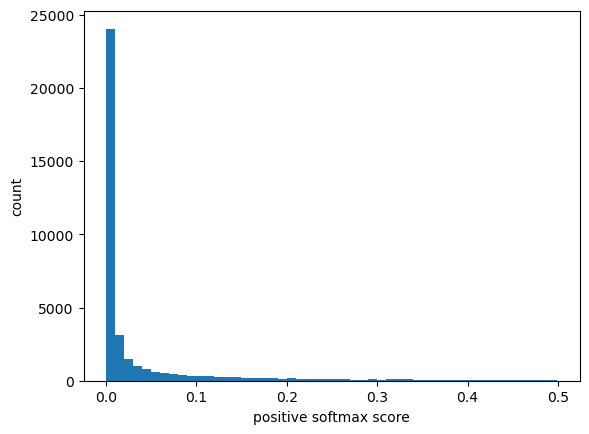

In [780]:
import ast
import matplotlib.pyplot as plt

pos_scores = (
    signal_df[signal_df['classification'] == 'NEUTRAL']['softmax']
        .dropna()
        .apply(ast.literal_eval)        # string -> dict
        .apply(lambda d: d['positive']) # extract positive prob
)

plt.hist(pos_scores, bins=50)
plt.xlabel("positive softmax score")
plt.ylabel("count")
plt.show()


In [781]:
filtered_df = signal_df.dropna(subset=['matched_ticker'])
filtered_df = filtered_df.rename(columns={'matched_ticker': 'TICKER'}) 

In [782]:
len(filtered_df['date'].unique())

2190

In [783]:
len(Counter(filtered_df['date']))

2190

In [784]:
########################################
# WEEKLY SIGNAL AGGREGATION
########################################

import ast
import numpy as np


def _softmax_sentiment_score(value):
    """Convert stored softmax dict/string into a signed sentiment score."""
    if pd.isna(value):
        return np.nan
    if isinstance(value, dict):
        scores = value
    else:
        try:
            scores = ast.literal_eval(value)
        except (ValueError, SyntaxError):
            return np.nan
    if not isinstance(scores, dict):
        return np.nan
    pos = float(scores.get('positive', 0.0))
    neg = float(scores.get('negative', 0.0))
    return pos - neg


def build_weekly_softmax_signal(df: pd.DataFrame) -> pd.DataFrame:
    work = df.dropna(subset=['TICKER']).copy()
    work['article_dt'] = pd.to_datetime(work['date'], utc=True, errors='coerce').dt.tz_convert(None)
    work['signal_score'] = work['softmax'].apply(_softmax_sentiment_score)
    work = work.dropna(subset=['article_dt', 'signal_score'])
    work['week_date'] = work['article_dt'].dt.to_period('W-THU').dt.start_time

    weekly = (
        work.groupby(['TICKER', 'week_date'])
            .agg({
                'signal_score': 'mean',
                'classification': lambda x: x.value_counts().idxmax(),
                'article_dt': 'count'
            })
            .rename(columns={'classification': 'top_class', 'article_dt': 'n_articles'})
            .reset_index()
    )
    weekly['signal_score'] = weekly['signal_score'].fillna(0.0)
    return weekly

weekly_signal = build_weekly_softmax_signal(filtered_df)
weekly_signal.head()


,TICKER,week_date,signal_score,top_class,n_articles
0,AAPL,2016-12-30,-0.252525,NEUTRAL,2
1,AAPL,2017-01-06,0.047567,NEUTRAL,4
2,AAPL,2017-01-13,0.002246,NEUTRAL,2
3,AAPL,2017-01-20,-0.001281,NEUTRAL,5
4,AAPL,2017-01-27,0.069523,NEUTRAL,5


In [785]:
weekly_signal[weekly_signal['TICKER'] == 'MSFT'].sort_values('week_date')

,TICKER,week_date,signal_score,top_class,n_articles
8751,MSFT,2017-01-06,-0.095761,NEUTRAL,4
8752,MSFT,2017-01-13,0.021881,NEUTRAL,3
8753,MSFT,2017-01-20,-0.039158,NEUTRAL,3
8754,MSFT,2017-01-27,-0.009326,NEUTRAL,4
8755,MSFT,2017-02-03,-0.003612,NEUTRAL,3
...,...,...,...,...,...
9027,MSFT,2022-11-11,0.072480,NEUTRAL,1
9028,MSFT,2022-11-18,-0.111766,NEUTRAL,2
9029,MSFT,2022-12-02,-0.016343,NEUTRAL,2
9030,MSFT,2022-12-09,0.132038,NEUTRAL,2


In [786]:
import pandas as pd
import numpy as np

def compute_ticker_weekly(
    ret_df: pd.DataFrame,
    lookback_weeks: int = 52,
    skip_weeks: int = 4,
    week_rule: str = "W-FRI",
    col_ticker: str = "TICKER",
    col_date: str = "date",
    col_ret: str = "RET",
    out_mom: str = "MOM",
    out_wret: str = "RET",
    return_daily_aligned: bool = False,
    ffill_to_next_week: bool = False
) -> pd.DataFrame:
    """
    Weekly L–G momentum using *weekly* compounded returns, also includes weekly returns.

    Momentum on week t is cumulative return from [t-(G+L)+1, ..., t-G] in weeks.

    If return_daily_aligned=False -> returns a weekly panel (PERMNO-week level).
    If return_daily_aligned=True  -> merges weekly MOM and weekly RET back to the daily panel.
    """
    df = ret_df.copy()
    df[col_date] = pd.to_datetime(df[col_date])
    df = df.sort_values([col_ticker, col_date])

    # === 1. Convert daily returns to weekly log-returns ===
    df["_logret"] = np.log1p(df[col_ret].astype(float).fillna(0.0).clip(lower=-0.999999))

    # === 2. Resample to weekly frequency per ticker ===
    wk = (
        df.set_index(col_date)
          .groupby(col_ticker, group_keys=True)["_logret"]
          .resample(week_rule)
          .sum()
          .rename("logret_w")
          .reset_index()
    )

    # Weekly compounded simple return
    wk[out_wret] = np.expm1(wk["logret_w"])

    # === 3. Compute cumulative sums of weekly log returns ===
    wk["csum"] = wk.groupby(col_ticker)["logret_w"].cumsum()

    # End of window: t - G
    wk["csum_end"] = wk.groupby(col_ticker)["csum"].shift(skip_weeks)

    # Start of window: t - (L+G)
    wk["csum_start"] = wk.groupby(col_ticker)["csum_end"].shift(lookback_weeks)

    wk_out = wk[[col_ticker, col_date, out_wret]].rename(columns={col_date: "week_date"})
    wk_out["week_date"] = pd.to_datetime(wk_out["week_date"]).dt.to_period("W-THU").dt.start_time

    # === 5. Return weekly panel ===
    if not return_daily_aligned:
        return wk_out

    # === 6. Or merge back to daily panel ===
    daily = ret_df.copy()
    daily[col_date] = pd.to_datetime(daily[col_date])

    # build mapping from each daily date to its week anchor (Friday)
    all_days = (
        daily[[col_date]]
        .drop_duplicates()
        .sort_values(col_date)
        .set_index(col_date)
    )
    anchors = all_days.resample(week_rule).last().index
    mapper = pd.Series(anchors, index=anchors)
    mapper = mapper.reindex(all_days.index, method="ffill")
    mapper.name = "week_date"
    mapper = mapper.reset_index().rename(columns={col_date: "date"})

    daily = daily.merge(mapper, left_on=col_date, right_on="date", how="left").drop(columns=["date"])
    out = daily.merge(wk_out, on=[col_ticker, "week_date"], how="left")

    if ffill_to_next_week:
        out = out.sort_values([col_ticker, col_date])
        out[[out_mom, out_wret]] = out.groupby(col_ticker)[[out_mom, out_wret]].ffill()

    return out


In [787]:
ret_df = pd.read_csv('momentum/s&p100ret.csv')
ret_df['TICKER'] = ret_df['TICKER'].str.strip() 
ret_df['RET'] = pd.to_numeric(ret_df['RET'], errors='coerce') 
ret_df['date'] = pd.to_datetime(ret_df['date'], format='%Y-%m-%d')
#ret_df = ret_df.dropna(subset=['RET'])
weekly_returns = compute_ticker_weekly(ret_df, lookback_weeks=12, skip_weeks=1)
weekly_returns.head()


/var/folders/b7/s8_nr_vd3bvcht_hmrmyy47h0000gn/T/ipykernel_55149/1046434888.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ret_df = pd.read_csv('momentum/s&p100ret.csv')


,TICKER,week_date,RET
0,AAPL,2019-01-04,-0.060099
1,AAPL,2019-01-11,0.027182
2,AAPL,2019-01-18,0.029747
3,AAPL,2019-01-25,0.005994
4,AAPL,2019-02-01,0.055527


In [788]:
weekly_alpha = (
    weekly_returns.merge(weekly_signal, on=['TICKER', 'week_date'], how='left')
        .rename(columns={'signal_score': 'SENT'})
        .sort_values(['week_date', 'TICKER'])
        .reset_index(drop=True)
)


In [789]:
########################################
# WEEKLY BACKTEST
########################################

import numpy as np

LONG_PCT = 0.1
SHORT_PCT = 0.1
LEVERAGE = 1.0
HOLDING_WEEKS = 1
SP500_RET_PATH = "../data/snp500_ret.csv"


def load_sp500_weekly(csv_path: str = SP500_RET_PATH) -> pd.DataFrame:
    sp = pd.read_csv(csv_path)
    sp = sp.rename(columns={'caldt': 'date', 'sprtrn': 'sp500_ret'})
    sp['date'] = pd.to_datetime(sp['date'])
    sp['sp500_ret'] = pd.to_numeric(sp['sp500_ret'], errors='coerce')
    sp = sp.dropna(subset=['sp500_ret'])
    sp['week_date'] = sp['date'].dt.to_period('W-THU').dt.start_time

    weekly = (
        sp.groupby('week_date')['sp500_ret']
          .apply(lambda x: (1 + x).prod() - 1)
          .reset_index(name='sp500_ret')
    )
    return weekly


def prepare_weekly_signal(df: pd.DataFrame, signal_col: str) -> pd.DataFrame:
    use_cols = ['week_date', 'TICKER', 'RET', signal_col]
    out = df[use_cols].dropna(subset=['RET']).copy()
    out['week_date'] = pd.to_datetime(out['week_date'])
    out['RET'] = pd.to_numeric(out['RET'], errors='coerce')
    return out.dropna(subset=['RET']).sort_values(['TICKER', 'week_date'])


def make_signal(df_slice: pd.DataFrame, col_signal: str) -> pd.Series:
    return df_slice.set_index('TICKER')[col_signal]


def construct_weights(signal_cs: pd.Series,
                      long_pct=LONG_PCT,
                      short_pct=SHORT_PCT,
                      gross_leverage=LEVERAGE) -> pd.Series:
    sig = signal_cs.dropna()
    if sig.empty:
        return pd.Series(dtype=float)
    n = len(sig)
    n_long = max(1, int(round(n * long_pct)))
    n_short = max(1, int(round(n * short_pct)))
    ranked = sig.sort_values(ascending=False)
    w_long = pd.Series(1 / n_long, index=ranked.index[:n_long])
    w_short = pd.Series(-1 / n_short, index=ranked.index[-n_short:])
    w = pd.concat([w_long, w_short])
    gross = w.abs().sum()
    if gross > 0:
        w *= gross_leverage / gross
    return w


def build_weight_panel(df: pd.DataFrame,
                       holding_weeks: int,
                       col_signal: str) -> pd.DataFrame:
    all_weeks = sorted(df['week_date'].unique())
    recs = []

    for w in all_weeks:
        cs_slice = df[df['week_date'] == w]
        sig_cs = make_signal(cs_slice, col_signal)
        w_cs = construct_weights(sig_cs)
        if w_cs.empty:
            continue
        hold_ix = all_weeks.index(w)
        hold_weeks = all_weeks[hold_ix: hold_ix + holding_weeks]
        for hw in hold_weeks:
            recs.append(pd.DataFrame({
                'week_date': hw,
                'TICKER': w_cs.index,
                'weight': w_cs.values
            }))
    return pd.concat(recs, ignore_index=True) if recs else pd.DataFrame(columns=['week_date', 'TICKER', 'weight'])


def compute_pnl_timeseries(df: pd.DataFrame, weight_panel: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['RET_fwd'] = df.groupby('TICKER')['RET'].shift(-1)

    merged = pd.merge(
        weight_panel,
        df[['TICKER', 'week_date', 'RET_fwd']],
        on=['TICKER', 'week_date'],
        how='left'
    )
    merged['pnl'] = merged['weight'] * merged['RET_fwd']

    def agg_pnl(x):
        long_pnl = x[x['weight'] > 0]['pnl'].sum()
        short_pnl = -1 * x[x['weight'] < 0]['pnl'].sum()
        return pd.Series({
            'port_ret_long': long_pnl,
            'port_ret_short': short_pnl,
            'port_ret': long_pnl - short_pnl
        })

    pnl = merged.groupby('week_date').apply(agg_pnl).reset_index()

    benchmark = (
        df.dropna(subset=['RET_fwd'])
          .groupby('week_date')['RET_fwd']
          .mean()
          .rename('benchmark_ret')
          .reset_index()
    )
    pnl = pnl.merge(benchmark, on='week_date', how='left')
    pnl['benchmark_ret'] = pnl['benchmark_ret'].fillna(0.0)
    pnl['excess_ret'] = pnl['port_ret'] - pnl['benchmark_ret']

    sp500 = load_sp500_weekly()
    pnl = pnl.merge(sp500, on='week_date', how='left')
    pnl['sp500_ret'] = pnl['sp500_ret'].fillna(0.0)

    pnl['port_value'] = (1 + pnl['port_ret']).cumprod()
    pnl['benchmark_value'] = (1 + pnl['benchmark_ret']).cumprod()
    pnl['sp500_value'] = (1 + pnl['sp500_ret']).cumprod()
    pnl['excess_value'] = (1 + pnl['excess_ret']).cumprod()

    return pnl


def run_weekly_signal_backtest(weekly_alpha: pd.DataFrame,
                               signal_col: str = 'SENT') -> dict:
    df = prepare_weekly_signal(weekly_alpha, signal_col)
    weight_panel = build_weight_panel(df, holding_weeks=HOLDING_WEEKS, col_signal=signal_col)
    weekly_perf = compute_pnl_timeseries(df, weight_panel)

    weeks = len(weekly_perf)
    horizon_weeks = min(weeks, 52 * 4)
    port_series = weekly_perf['port_value']
    value_4yr = port_series.iloc[horizon_weeks - 1] if horizon_weeks > 0 else np.nan

    weekly_ret = weekly_perf['port_ret']
    avg = weekly_ret.mean()
    vol = weekly_ret.std(ddof=1)
    sharpe = (avg / vol) * np.sqrt(52) if vol is not None and vol > 0 else np.nan

    roll_max = port_series.cummax()
    drawdown = (roll_max - port_series) / roll_max
    max_drawdown = drawdown.max() if not drawdown.empty else np.nan

    summary = {
        'start': weekly_perf['week_date'].min(),
        'end': weekly_perf['week_date'].max(),
        'weeks': weeks,
        'total_return': port_series.iloc[-1] - 1 if weeks else np.nan,
        'dollar_value_4yr': value_4yr,
        'annualized_sharpe': sharpe,
        'max_drawdown': max_drawdown,
        'sp500_total_return': weekly_perf['sp500_value'].iloc[-1] - 1 if weeks else np.nan
    }

    return {
        'weekly_perf': weekly_perf,
        'weights': weight_panel,
        'summary': summary
    }


backtest_results = run_weekly_signal_backtest(weekly_alpha, signal_col='SENT')
backtest_results['weekly_perf'].head()
backtest_results['summary']


/var/folders/b7/s8_nr_vd3bvcht_hmrmyy47h0000gn/T/ipykernel_55149/956712415.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pnl = merged.groupby('week_date').apply(agg_pnl).reset_index()


{'start': Timestamp('2019-01-04 00:00:00'),
 'end': Timestamp('2022-12-30 00:00:00'),
 'weeks': 209,
 'total_return': 1.8594945515416148,
 'dollar_value_4yr': 2.8435925937438027,
 'annualized_sharpe': 1.520701288724693,
 'max_drawdown': 0.15643459377295338,
 'sp500_total_return': 0.555643836167953}

In [790]:
backtest_results['weekly_perf']['cum_ret_long'] = np.cumprod(1 + backtest_results['weekly_perf']['port_ret_long']) - 1
backtest_results['weekly_perf']['cum_ret_short'] = np.cumprod(1 + backtest_results['weekly_perf']['port_ret_short']) - 1
backtest_results['weekly_perf']['cum_ret'] = np.cumprod(1 + backtest_results['weekly_perf']['port_ret']) - 1
backtest_results['weekly_perf']['benchmark_cum_ret'] = np.cumprod(1 + backtest_results['weekly_perf']['benchmark_ret']) - 1
backtest_results['weekly_perf']['sp500_cum_ret'] = backtest_results['weekly_perf']['sp500_value'] - 1


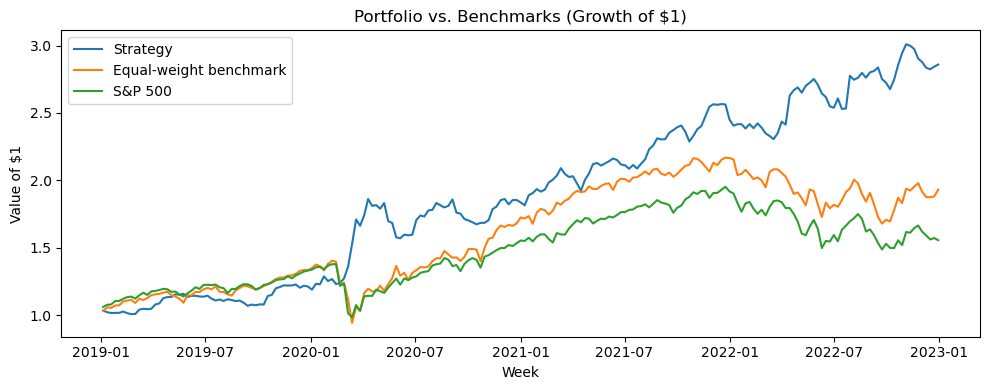

In [791]:
perf = backtest_results['weekly_perf']
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(perf['week_date'], perf['port_value'], label='Strategy')
ax.plot(perf['week_date'], perf['benchmark_value'], label='Equal-weight benchmark')
ax.plot(perf['week_date'], perf['sp500_value'], label='S&P 500')
ax.set_title('Portfolio vs. Benchmarks (Growth of $1)')
ax.set_xlabel('Week')
ax.set_ylabel('Value of $1')
ax.legend()
plt.tight_layout()


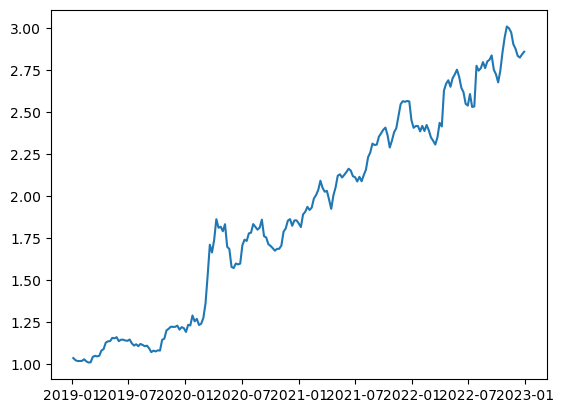

In [795]:
plt.plot(backtest_results['weekly_perf']['week_date'], backtest_results['weekly_perf']['port_value'], label='Strategy')

<Axes: title={'center': 'Weekly Momentum Backtest vs Benchmarks'}, xlabel='week_date'>

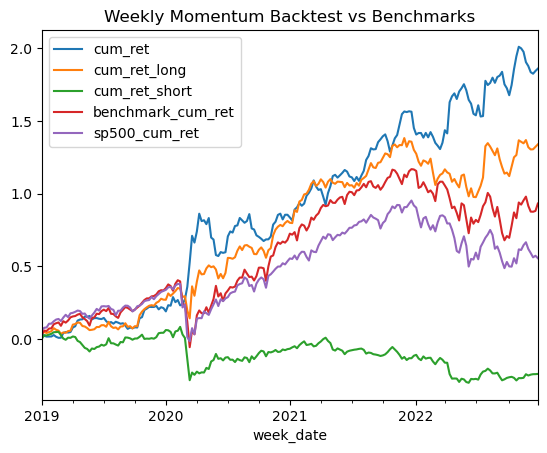

In [796]:
backtest_results['weekly_perf'][['week_date','cum_ret', 'cum_ret_long', 'cum_ret_short', 'benchmark_cum_ret', 'sp500_cum_ret']].plot(x='week_date', y=['cum_ret', 'cum_ret_long', 'cum_ret_short', 'benchmark_cum_ret', 'sp500_cum_ret'],
      title='Weekly Momentum Backtest vs Benchmarks')


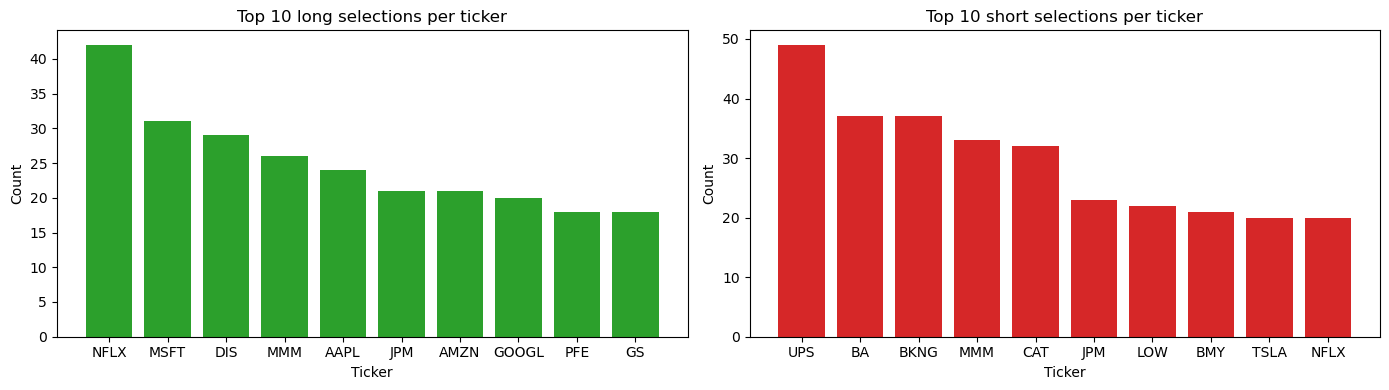

In [690]:
# Histogram: selection frequency by ticker
import matplotlib.pyplot as plt

weights = backtest_results['weights'].copy()
long_counts = (
    weights[weights['weight'] > 0]
        .groupby('TICKER')
        .size()
        .rename('long_count')
)
short_counts = (
    weights[weights['weight'] < 0]
        .groupby('TICKER')
        .size()
        .rename('short_count')
)
selection_counts = (
    pd.concat([long_counts, short_counts], axis=1)
      .fillna(0)
      .sort_values('long_count', ascending=False)
)
selection_counts.head(10)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
top_long = long_counts.sort_values(ascending=False).head(10)
top_short = short_counts.sort_values(ascending=False).head(10)
axes[0].bar(top_long.index, top_long.values, color='tab:green')
axes[0].set_title('Top 10 long selections per ticker')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Ticker')

axes[1].bar(top_short.index, top_short.values, color='tab:red')
axes[1].set_title('Top 10 short selections per ticker')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Ticker')

plt.tight_layout()


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,horizon_weeks,ic
0,1,0.068837
1,2,0.036645
2,3,-0.009414
3,4,-0.001941
4,5,-0.018963
5,6,-0.014341


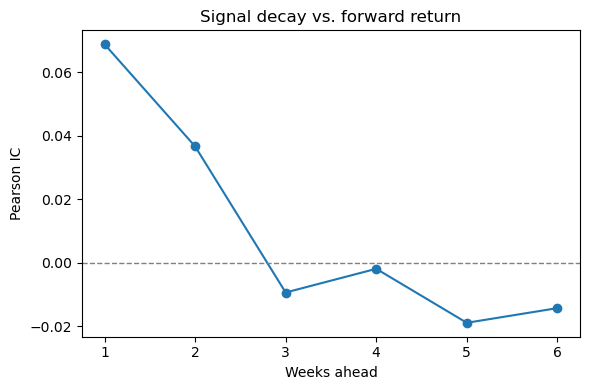

In [714]:
########################################
# SIGNAL DECAY: FUTURE IC
########################################

MAX_HORIZON = 6  # weeks into the future

def compute_future_ic(panel: pd.DataFrame, horizon: int) -> float:
    shifted = panel.copy()
    shifted['RET_fwd'] = shifted.groupby('TICKER')['RET'].shift(-horizon)
    records = []
    for date, g in shifted.groupby('week_date'):
        if g['SENT'].notna().sum() < 5:
            continue
        ic = g['SENT'].corr(g['RET_fwd'])
        if pd.notna(ic):
            records.append(ic)
    return np.mean(records) if records else np.nan

future_ics = []
for h in range(1, MAX_HORIZON + 1):
    ic_val = compute_future_ic(weekly_alpha, h)
    future_ics.append({'horizon_weeks': h, 'ic': ic_val})

decay_df = pd.DataFrame(future_ics)
print(decay_df)

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(decay_df['horizon_weeks'], decay_df['ic'], marker='o')
ax.axhline(0, color='gray', linewidth=1, linestyle='--')
ax.set_xlabel('Weeks ahead')
ax.set_ylabel('Pearson IC')
ax.set_title('Signal decay vs. forward return')
plt.tight_layout()
decay_df


In [705]:
########################################
# RANK IC & T-STAT
########################################

from scipy import stats

weekly_alpha_sorted = weekly_alpha.sort_values(['week_date', 'TICKER']).copy()
ic_records = []
for date, g in weekly_alpha_sorted.groupby('week_date'):
    if g['SENT'].notna().sum() < 3:
        continue
    ic = g['SENT'].corr(g['RET'], method='spearman')
    ic_records.append({'week_date': date, 'rank_ic': ic})

ic_df = pd.DataFrame(ic_records).dropna()
mean_ic = ic_df['rank_ic'].mean() if not ic_df.empty else np.nan
std_ic = ic_df['rank_ic'].std(ddof=1) if len(ic_df) > 1 else np.nan
t_stat = (mean_ic / (std_ic / np.sqrt(len(ic_df)))) if std_ic and std_ic > 0 else np.nan

print(f'Mean rank IC: {mean_ic:.4f}')
print(f'T-stat: {t_stat:.2f}')
ic_df.head()


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,week_date,rank_ic
0,2019-01-04,0.214035
1,2019-01-11,0.412030
2,2019-01-18,0.210390
3,2019-01-25,-0.089783
4,2019-02-01,-0.291228


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Pearson corr (sentiment vs. momentum): 0.0877
Spearman rank corr: 0.1059
Rank-corr t-stat: 7.05 (n=4386)


,TICKER,week_date,RET,SENT,top_class,n_articles,MOM
0,AAPL,2019-03-29,-0.005758,0.218582,NEUTRAL,3.0,0.216357
9,AMZN,2019-03-29,0.009053,-0.004698,NEUTRAL,6.0,0.174966
12,BA,2019-03-29,0.053152,-0.185323,NEUTRAL,2.0,0.128703
16,BKNG,2019-03-29,0.013544,-0.267629,NEUTRAL,1.0,-0.000483
18,BMY,2019-03-29,-0.009344,0.435676,NEUTRAL,1.0,-0.065071


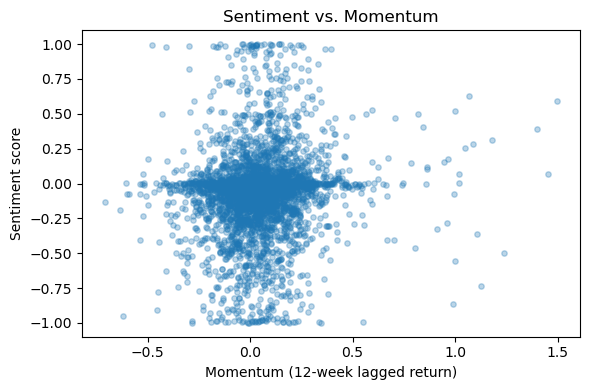

In [706]:
########################################
# SENTIMENT VS MOMENTUM
########################################

LOOKBACK_WEEKS = 12

mom_panel = weekly_returns.sort_values(['TICKER', 'week_date']).copy()
mom_panel['logret'] = np.log1p(mom_panel['RET'].clip(lower=-0.999999))
mom_panel['mom_log'] = (
    mom_panel.groupby('TICKER')['logret']
             .transform(lambda s: s.rolling(window=LOOKBACK_WEEKS, min_periods=LOOKBACK_WEEKS)
                                   .sum()
                                   .shift(1))
)
mom_panel['MOM'] = np.expm1(mom_panel['mom_log'])
momentum_panel = mom_panel.dropna(subset=['MOM'])[['TICKER', 'week_date', 'MOM']]

alpha_mom = (
    weekly_alpha.merge(momentum_panel, on=['TICKER', 'week_date'], how='inner')
                .dropna(subset=['SENT', 'MOM'])
)

pearson_corr = alpha_mom['SENT'].corr(alpha_mom['MOM'])
spearman_corr = alpha_mom['SENT'].corr(alpha_mom['MOM'], method='spearman')
obs = len(alpha_mom)
t_stat = (spearman_corr * np.sqrt((obs - 2) / (1 - spearman_corr**2))) if obs > 2 and abs(spearman_corr) < 1 else np.nan

print(f"Pearson corr (sentiment vs. momentum): {pearson_corr:.4f}")
print(f"Spearman rank corr: {spearman_corr:.4f}")
print(f"Rank-corr t-stat: {t_stat:.2f} (n={obs})")

fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(alpha_mom['MOM'], alpha_mom['SENT'], alpha=0.3, s=15)
ax.set_xlabel(f'Momentum ({LOOKBACK_WEEKS}-week lagged return)')
ax.set_ylabel('Sentiment score')
ax.set_title('Sentiment vs. Momentum')
plt.tight_layout()
alpha_mom.head()


In [710]:
########################################
# REGRESSION INFERENCE (RET ~ SENT)
########################################

import statsmodels.api as sm

reg_df = weekly_alpha.dropna(subset=['SENT', 'RET']).copy()
reg_df['RET'] = reg_df['RET'].astype(float)

if len(reg_df) < 5:
    print('Not enough observations for regression.')
else:
    X = sm.add_constant(reg_df['SENT'])
    model = sm.OLS(reg_df['RET'], X).fit(cov_type='HC1')
    print(model.summary())
    coeffs = model.params.rename({'const': 'alpha', 'SENT': 'beta_sent'})
    print('Robust t-stats:')
    print(model.tvalues)
    coeffs


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     5.705
Date:                Mon, 17 Nov 2025   Prob (F-statistic):             0.0170
Time:                        16:26:16   Log-Likelihood:                 7133.5
No. Observations:                4649   AIC:                        -1.426e+04
Df Residuals:                    4647   BIC:                        -1.425e+04
Df Model:                           1                                         
Covariance Type:                  HC1  